### 1. Environment Setup & Data Loading

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays 
from sklearn.model_selection import train_test_split
import os
#RANDOM_STATE = 42
#!pip install holidays


adir=0
if(adir==1):
    raw_data = pd.read_csv(r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data\raw_data.csv")
    base_path = r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data" 
else:
    raw_data = pd.read_csv(r"C:\Users\97252\Desktop\Chen_proj\data\raw_data.csv")
    base_path =  r"C:\Users\97252\Desktop\Chen_proj\data"


### 2. Initial Data Assessment & Type Handling

##### 2.1 Data Types

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29744 entries, 0 to 29743
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             29744 non-null  int64  
 1   OCCUR_DATE               29744 non-null  object 
 2   OCCUR_TIME               29744 non-null  object 
 3   BORO                     29744 non-null  object 
 4   LOC_OF_OCCUR_DESC        4148 non-null   object 
 5   PRECINCT                 29744 non-null  int64  
 6   JURISDICTION_CODE        29742 non-null  float64
 7   LOC_CLASSFCTN_DESC       4148 non-null   object 
 8   LOCATION_DESC            14767 non-null  object 
 9   STATISTICAL_MURDER_FLAG  29744 non-null  bool   
 10  PERP_AGE_GROUP           20400 non-null  object 
 11  PERP_SEX                 20434 non-null  object 
 12  PERP_RACE                20434 non-null  object 
 13  VIC_AGE_GROUP            29744 non-null  object 
 14  VIC_SEX               

In [5]:
# Convert date and time columns
raw_data['OCCUR_DATE'] = pd.to_datetime(raw_data['OCCUR_DATE'], format='%m/%d/%Y')
raw_data['OCCUR_TIME'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S').dt.time

# Convert integer and boolean types
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('Int64')
raw_data['STATISTICAL_MURDER_FLAG'] = raw_data['STATISTICAL_MURDER_FLAG'].astype(bool)

# Convert categorical columns
categorical_cols = ['BORO', 'PERP_SEX','PERP_RACE', 'PERP_AGE_GROUP',
'VIC_SEX', 'VIC_RACE', 'VIC_AGE_GROUP','LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC','PRECINCT']

for col in categorical_cols:
    raw_data[col] = raw_data[col].astype('category')

# Remove commas from coordinates (handle as string first)
raw_data['X_COORD_CD'] = raw_data['X_COORD_CD'].astype(str).str.replace(',', '')
raw_data['Y_COORD_CD'] = raw_data['Y_COORD_CD'].astype(str).str.replace(',', '')

# Convert to float
raw_data['X_COORD_CD'] = pd.to_numeric(raw_data['X_COORD_CD'], errors='coerce')
raw_data['Y_COORD_CD'] = pd.to_numeric(raw_data['Y_COORD_CD'], errors='coerce')

In [6]:
raw_data.dtypes

INCIDENT_KEY                        int64
OCCUR_DATE                 datetime64[ns]
OCCUR_TIME                         object
BORO                             category
LOC_OF_OCCUR_DESC                category
PRECINCT                         category
JURISDICTION_CODE                   Int64
LOC_CLASSFCTN_DESC               category
LOCATION_DESC                    category
STATISTICAL_MURDER_FLAG              bool
PERP_AGE_GROUP                   category
PERP_SEX                         category
PERP_RACE                        category
VIC_AGE_GROUP                    category
VIC_SEX                          category
VIC_RACE                         category
X_COORD_CD                        float64
Y_COORD_CD                        float64
Latitude                          float64
Longitude                         float64
Lon_Lat                            object
dtype: object

In [7]:
# Check the type of the first element in the column
print(type(raw_data['OCCUR_TIME'].iloc[0]))

<class 'datetime.time'>


Objective: Ensuring each feature is represented by its correct data type to optimize memory usage and enable proper mathematical and categorical operations.

Logic & Flow:

Temporal: OCCUR_DATE and OCCUR_TIME are converted to datetime objects to allow for time-based analysis.

Categorical: High-cardinality and descriptive columns are cast to category. 

Spatial: Geographic coordinates were cleaned of formatting artifacts (commas)

Validation: We use .info() and .dtypes to verify the transformation was successful.

##### 2.2 Duplicate Rows

In [8]:
raw_data.duplicated().sum()

np.int64(0)

##### 3. Define Target Variable

Objective: Establish the binary classification target for our models by transforming the raw indicator into a numerical format and analyzing its class distribution.

Logic:

Transformation: The original STATISTICAL_MURDER_FLAG (Boolean) is converted into an integer-based target is_murder (0 for non-fatal, 1 for fatal). This is a prerequisite for the machine learning algorithms we plan to use.

Redundancy Removal: The source column is dropped to maintain a clean feature set and prevent accidental data leakage during training.

Target Distribution Analysis: The output of .value_counts() reveals the following distribution:

Non-Fatal (0): 23,979 incidents

Fatal (1): 5,765 incidents

This confirms a significant Class Imbalance (roughly 19.4% fatal cases). This finding is critical for our methodology as it justifies:

The use of Stratified Splitting to ensure the minority class is represented proportionally in all data subsets.


In [ ]:
source_col = 'STATISTICAL_MURDER_FLAG'
target_col = 'is_murder'

if source_col in raw_data.columns:
    # 1. Convert Boolean (True/False) to Integer (1/0)
    raw_data[target_col] = raw_data[source_col].astype(int)

    # 2. Drop the original column 
    raw_data.drop(columns=[source_col], inplace=True)
    print(f"Dropped original column '{source_col}'.")

else:
    print(f"Column '{source_col}' not found (likely already dropped).")


print(f"Target Distribution:")
print(raw_data[target_col].value_counts())


Dropped original column 'STATISTICAL_MURDER_FLAG'.
Target Distribution:
is_murder
0    23979
1     5765
Name: count, dtype: int64


##### 3.1 Drop Irrelevant Columns

In [ ]:
if 'INCIDENT_KEY' in raw_data.columns:
    raw_data.drop(columns=['INCIDENT_KEY'], inplace=True)
else:
    print("INCIDENT_KEY' not found (already dropped).")

Goal: Avoid dropping rows with missing values by cross-referencing different coordinate systems.

Findings & Logic:

The Issue: We identified 97 rows with missing Latitude/Longitude data. In many cases, this would lead to dropping these rows and losing valuable data.

The Solution: We noticed that the X_COORD_CD and Y_COORD_CD columns were fully populated (0 missing values).

Verification: By calculating the correlation and plotting the regression, we proved they represent the exact same geographic points (1.0 correlation).

Conclusion: This cross-referencing allows us to "save" those 97 incidents. We can rely on the X/Y coordinates to represent the location, ensuring zero data loss before we proceed to clean up the redundant columns.

In [ ]:
cols = ['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat']
print("Counting Missing Values:")
print(raw_data[cols].isnull().sum())

Counting Missing Values:
X_COORD_CD     0
Y_COORD_CD     0
Latitude      97
Longitude     97
Lon_Lat       97
dtype: int64


Correlation Matrix
            X_COORD_CD  Y_COORD_CD  Latitude  Longitude
X_COORD_CD    1.000000    0.138655  0.137934   0.999998
Y_COORD_CD    0.138655    1.000000  1.000000   0.140439
Latitude      0.137934    1.000000  1.000000   0.139860
Longitude     0.999998    0.140439  0.139860   1.000000


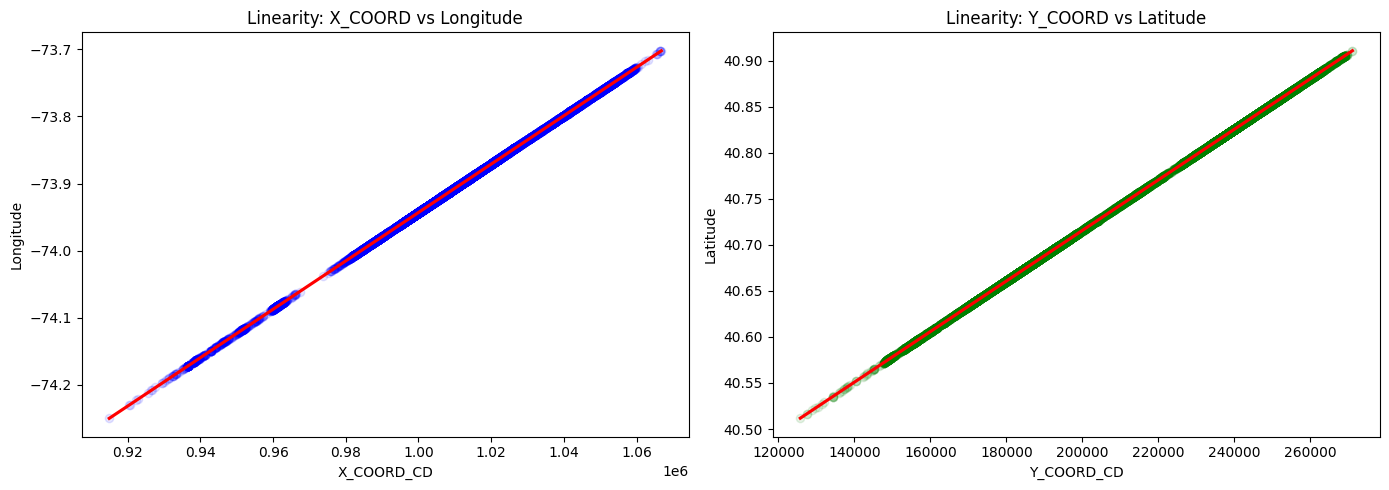

In [13]:
# 1. Necessary cleaning (removing commas and converting to numbers to prevent errors)
for col in ['X_COORD_CD', 'Y_COORD_CD']:
    if raw_data[col].dtype == 'object':
        raw_data[col] = raw_data[col].astype(str).str.replace(',', '').astype(float)

# 2. Print correlation matrix (text, not image)
cols = ['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']
print("Correlation Matrix")
print(raw_data[cols].corr())

# 3. Graphs to prove linearity (X and Y)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot X vs Longitude
sns.regplot(ax=ax[0], x=raw_data['X_COORD_CD'], y=raw_data['Longitude'],
            scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
ax[0].set_title('Linearity: X_COORD vs Longitude')

# Plot Y vs Latitude
sns.regplot(ax=ax[1], x=raw_data['Y_COORD_CD'], y=raw_data['Latitude'],
            scatter_kws={'alpha': 0.1, 'color': 'green'}, line_kws={'color': 'red'})
ax[1].set_title('Linearity: Y_COORD vs Latitude')

plt.tight_layout()
plt.show()

In [14]:
raw_data[['Latitude', 'Longitude', 'Lon_Lat']].dropna().head()

,Latitude,Longitude,Lon_Lat
0,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,40.872349,-73.868233,POINT (-73.868233 40.872349)
3,40.642490,-73.996912,POINT (-73.99691224999998 40.642489932000046)
4,40.845984,-73.907461,POINT (-73.90746098599993 40.84598358900007)


In [15]:
raw_data.drop(columns=['Latitude', 'Longitude', 'Lon_Lat'], inplace=True)

### 4. Domain-Specific Sanity Checks & Logic

#####  Logic Validation - Category

Objective: To ensure high data quality and uncover hidden patterns in missing values, we developed two custom diagnostic tools. These functions allow us to perform deep-dives into categorical consistency and structural gaps in the dataset.

Logic & Tools:

inspect_columns (Data Profiling Tool):

Purpose: Provides a rapid overview of categorical features. It separates "small" categories (like Sex or Age Group) for value inspection and "large" categories (like Precincts) for summary.

Value: This helps identify "garbage" values, typos, or illogical entries that automated tools might miss.

plot_structural_missingness (Gap Analysis Tool):

Purpose: This function analyzes whether missing data occurs in "clusters." It classifies rows as having Complete, Partial, or Total missing information for a given set of columns.

Value: It is specifically designed to test our hypothesis regarding suspect data—verifying if missing values are random errors or represent a systematic "unknown" status (e.g., cases where the perpetrator was never identified).

In [ ]:
def inspect_columns(df, cols_list, title="Columns", threshold=15, show_all=False):

    large_cols = []
    
    print(f"Inspecting: {title}")
    
    for col in cols_list:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
            
        unique_vals = df[col].unique()
        n_unique = len(unique_vals)
        
        if n_unique <= threshold or show_all:
            print(f"Column: {col} ({n_unique} values)")

            try:
                sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
                print(f"Values: {sorted_vals}")
            except:
                print(f"Values: {unique_vals.tolist()}")
 
            nans = df[col].isnull().sum()
            if nans > 0:
                print(f"Contains {nans} NaNs")
            
            print("-" * 40)
        
        else:
    
            large_cols.append(col)

    if large_cols and not show_all:
        print(f"\n" + "="*40)
        print(f"{len(large_cols)} Large Columns (>{threshold} values)")
        for col in large_cols:
            n_val = df[col].nunique()
            print(f"{col} ({n_val} values)")
        print("="*40)
    elif not large_cols and not show_all:
        print(f"All columns in this group were small (<= {threshold}).")
        
    return large_cols

In [ ]:
def plot_structural_missingness(df, cols, garbage_vals, title, custom_labels=None):

    print(f"Analyzing: {title}")
    
    missing_mask = df[cols].isin(garbage_vals) | df[cols].isnull()
    row_missing_sum = missing_mask.sum(axis=1)
    n_cols = len(cols)

    if custom_labels is None:
        labels = ['Complete Info', 'All Missing', 'Partial Info']
    else:
        labels = custom_labels

    conditions = [
        (row_missing_sum == 0),        
        (row_missing_sum == n_cols),    
        (row_missing_sum > 0) & (row_missing_sum < n_cols) 
    ]
    
   
    quality_series = np.select(conditions, labels, default='Other')
    

    counts = pd.Series(quality_series).value_counts()
    ordered_counts = counts.reindex(labels).fillna(0)

    print(ordered_counts)


    plt.figure(figsize=(5, 5))
    colors = sns.color_palette('pastel')[0:3]
    explode = (0.05, 0.05, 0.1) 
    
    plt.pie(ordered_counts, 
            labels=ordered_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=colors,
            explode=explode,
            shadow=True,
            textprops={'fontsize': 10, 'weight': 'bold'})
    
    plt.title(title, fontsize=12)
    plt.show()

In [18]:
perp_cols = ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
inspect_columns(raw_data, perp_cols, title="Suspect Data")

Inspecting: Suspect Data
Column: PERP_AGE_GROUP (13 values)
Values: ['(null)', '1020', '1028', '18-24', '2021', '224', '25-44', '45-64', '65+', '940', '<18', 'UNKNOWN', nan]
Contains 9344 NaNs
----------------------------------------
Column: PERP_SEX (5 values)
Values: ['(null)', 'F', 'M', 'U', nan]
Contains 9310 NaNs
----------------------------------------
Column: PERP_RACE (9 values)
Values: ['(null)', 'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC', nan]
Contains 9310 NaNs
----------------------------------------
All columns in this group were small (<= 15).


[]

Objective: To validate our hypothesis that missing perpetrator data is not random but "structural"—meaning it represents cases where the suspect was never identified or caught.

Methodology: We utilized our custom plot_structural_missingness function, passing a specific "garbage list" derived from our earlier profiling. This list includes NaN values, technical strings like (null), and the illogical numeric codes (e.g., 1020, 2021).

Analyzing: Suspect Data Completeness
Complete Info (Caught)    15460
All Missing (Unknown)     12404
Partial Info               1880
Name: count, dtype: int64


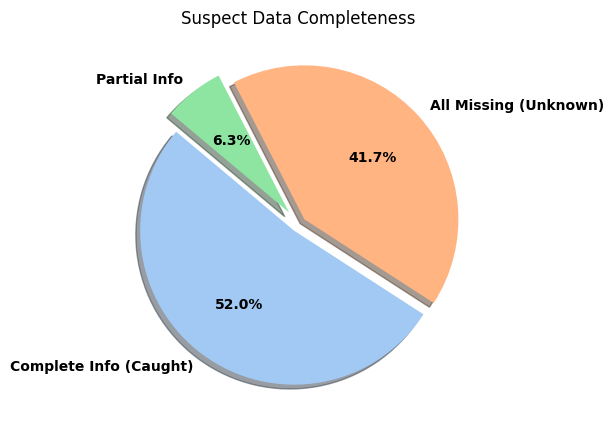

In [ ]:

perp_cols = ['PERP_SEX', 'PERP_RACE', 'PERP_AGE_GROUP']
perp_garbage = [np.nan, '(null)', 'UNKNOWN', 'U', '1020', '940', '224', '2021', '1022']
perp_labels = ['Complete Info (Caught)', 'All Missing (Unknown)', 'Partial Info']


plot_structural_missingness(
    raw_data, 
    perp_cols, 
    perp_garbage, 
    title='Suspect Data Completeness', 
    custom_labels=perp_labels
)

Key Findings from Visualization:

"All or Nothing" Synchronization: The pie chart reveals that in 41.7% of all incidents (12,404 cases), information is missing across all three suspect attributes simultaneously.

Minimal Partial Data: Only 6.3% of cases contain partial information, confirming that suspect data is almost always collected as a complete set or not at all.

The Identification Gap: Only 52% of the recorded shooting incidents in New York have complete demographic data for the perpetrator.

Strategic Conclusions:

Validation of Hypothesis: The high synchronization (41.7% "All Missing") proves that these are unsolved cases where the perpetrator remained anonymous, rather than random data entry errors.

Preserving Data Integrity: We will not drop these rows. Deleting nearly 48% of the dataset (All Missing + Partial) would lead to Survivorship Bias, as the model would only be trained on "solved" crimes.

Unified Imputation: To retain this critical "unsolved" signal for the model, we will map all identified garbage values to a standardized 'Unknown' category.

In [1]:

perp_cols = ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
garbage = ['(null)', 'UNKNOWN', 'U', '1020', '1028', '940', '224', '2021', np.nan]

raw_data[perp_cols] = raw_data[perp_cols].astype('object').replace(garbage, 'Unknown').fillna('Unknown').astype('category')

print("Suspect columns cleaned to 'Unknown'.")

NameError: name 'np' is not defined

In [21]:
vic_cols = ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']
inspect_columns(raw_data, vic_cols, title="Victim Data")

Inspecting: Victim Data
Column: VIC_AGE_GROUP (7 values)
Values: ['1022', '18-24', '25-44', '45-64', '65+', '<18', 'UNKNOWN']
----------------------------------------
Column: VIC_SEX (3 values)
Values: ['F', 'M', 'U']
----------------------------------------
Column: VIC_RACE (7 values)
Values: ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC']
----------------------------------------
All columns in this group were small (<= 15).


[]

In [22]:
# 1. Define victim columns
vic_cols = ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']

# 2. Specific garbage list for victims (based on your output)
# U = Abbreviation for Unknown
# 1022 = Unrealistic age
vic_garbage = ['U', '1022', 'UNKNOWN', '(null)'] 

print("Standardizing Victim Data")

# 3. Efficient one-line cleaning
# Convert to object -> Replace garbage -> Fill missing (safety) -> Convert back to category
raw_data[vic_cols] = raw_data[vic_cols].astype('object').replace(vic_garbage, 'Unknown').fillna('Unknown').astype('category')

print("Victim columns cleaned (U/1022 -> Unknown).")

Standardizing Victim Data
Victim columns cleaned (U/1022 -> Unknown).


Objective: Similar to the perpetrator attributes, we analyzed the demographic data of the victims. The goal here was to standardize "Unknown" values and clean illogical entries to ensure consistency across the dataset.

Logic & Observation:

Data Quality: Unlike the perpetrator data, victim information is significantly more complete since the victim is present at the scene.

Garbage Identification: Using inspect_columns, we identified small amounts of noise, such as the code 1022 in the age group and U (shorthand for Unknown) in the sex/race columns.

Action: We mapped these inconsistent labels to a single 'Unknown' category. This ensures that the model treats "Unknown" consistently, whether it appears in the suspect or victim features.

In [23]:
loc_cols = ['BORO', 'LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 'PRECINCT']
large_locations = inspect_columns(raw_data, loc_cols, title="Location Data")

Inspecting: Location Data
Column: BORO (5 values)
Values: ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
----------------------------------------
Column: LOC_OF_OCCUR_DESC (3 values)
Values: ['INSIDE', 'OUTSIDE', nan]
Contains 25596 NaNs
----------------------------------------
Column: LOC_CLASSFCTN_DESC (11 values)
Values: ['(null)', 'COMMERCIAL', 'DWELLING', 'HOUSING', 'OTHER', 'PARKING LOT', 'PLAYGROUND', 'STREET', 'TRANSIT', 'VEHICLE', nan]
Contains 25596 NaNs
----------------------------------------

2 Large Columns (>15 values)
LOCATION_DESC (40 values)
PRECINCT (77 values)


Analyzing: Location Data Completeness
Complete Loc Info         4141
No Loc Info (Unknown)    25596
Partial Loc Info             7
Name: count, dtype: int64


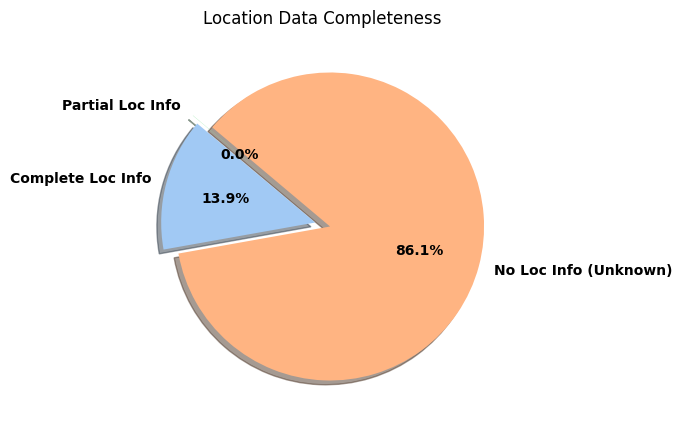

In [24]:
# Definitions for location
loc_cols = ['LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC']
loc_garbage = [np.nan, '(null)']
loc_labels = ['Complete Loc Info', 'No Loc Info (Unknown)', 'Partial Loc Info']

# Function call
plot_structural_missingness(
    raw_data, 
    loc_cols, 
    loc_garbage, 
    title='Location Data Completeness', 
    custom_labels=loc_labels
)

In [25]:
loc_cols = ['LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC']
loc_garbage = ['(null)', np.nan]

raw_data[loc_cols] = raw_data[loc_cols].astype('object').replace(loc_garbage, 'Unknown').fillna('Unknown').astype('category')

print(f"Location columns cleaned. Missing values mapped to 'Unknown'.")

Location columns cleaned. Missing values mapped to 'Unknown'.


Objective: Beyond geographic coordinates, the dataset provides descriptive location features (e.g., LOC_OF_OCCUR_DESC, LOC_CLASSFCTN_DESC). We aimed to evaluate the quality of these features and determine if the significant number of missing values followed a structural pattern similar to the perpetrator data.

Logic & Observations:

Identifying High Cardinality: Using inspect_columns, we identified that while some location features like BORO are complete, others contain highly specific or widely missing values.

Structural Gap Discovery: Our plot_structural_missingness analysis revealed a massive data gap: 86.1% of incidents lack descriptive location information entirely (25,596 cases). Only 13.9% (4,141 cases) provide complete descriptive details.

Synchronization: The nearly 0% Partial Info rate confirms that these descriptive fields are either filled as a pair or left blank by the reporting officer, likely depending on whether the shooting occurred in a specific identifiable venue or an open public space.

Implementation: Given the high percentage of missing values, dropping these rows is not an option. Instead, we standardized the "Unknown" signal to allow the model to distinguish between shootings with detailed environmental context versus those without.

In [26]:
pd.set_option('display.max_colwidth', None)
inspect_columns(raw_data, large_locations, title="Deep Dive: Large Location Columns", show_all=True)

Inspecting: Deep Dive: Large Location Columns
Column: LOCATION_DESC (41 values)
Values: ['(null)', 'ATM', 'BANK', 'BAR/NIGHT CLUB', 'BEAUTY/NAIL SALON', 'CANDY STORE', 'CHAIN STORE', 'CHECK CASH', 'CLOTHING BOUTIQUE', 'COMMERCIAL BLDG', 'DEPT STORE', 'DOCTOR/DENTIST', 'DRUG STORE', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'FAST FOOD', 'GAS STATION', 'GROCERY/BODEGA', 'GYM/FITNESS FACILITY', 'HOSPITAL', 'HOTEL/MOTEL', 'JEWELRY STORE', 'LIQUOR STORE', 'LOAN COMPANY', 'MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'NONE', 'PHOTO/COPY STORE', 'PVT HOUSE', 'RESTAURANT/DINER', 'SCHOOL', 'SHOE STORE', 'SMALL MERCHANT', 'SOCIAL CLUB/POLICY LOCATI', 'STORAGE FACILITY', 'STORE UNCLASSIFIED', 'SUPERMARKET', 'TELECOMM. STORE', 'VARIETY STORE', 'VIDEO STORE', nan]
Contains 14977 NaNs
----------------------------------------
Column: PRECINCT (77 values)
Values: [1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123, 13, 14, 17, 18, 19, 

[]

In [ ]:
loc_desc_garbage = ['(null)', 'NONE', np.nan]

print("Standardizing Specific Location Description:")

raw_data['LOCATION_DESC'] = raw_data['LOCATION_DESC'].astype('object').replace(loc_desc_garbage, 'Unknown').fillna('Unknown').astype('category')
print(f" LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.")

raw_data['PRECINCT'] = raw_data['PRECINCT'].astype('category')
print(f" PRECINCT validated and set to Category type.")


Standardizing Specific Location Description:
 LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.
 PRECINCT validated and set to Category type.


PRECINCT: Validated 77 unique codes. Explicitly set as Category to prevent the model from treating station numbers as mathematical values.

LOCATION_DESC: Identified that ~50% of specific location details were "hidden" under (null), NONE, or NaN.

Standardization: We unified these placeholders into a single 'Unknown' category. This preserves the 50% of high-quality data (like 'BAR/NIGHT CLUB') while ensuring the model handles the missing context consistently.

##### Feature Engineering: Semantic Grouping

In [28]:
# List of columns we want to check before grouping
cols_to_check = ['PERP_RACE', 'VIC_RACE','LOC_CLASSFCTN_DESC','LOCATION_DESC']

print("Frequency Check for Grouping Strategy")

for col in cols_to_check:
    if col in raw_data.columns:
        print(f"Column: {col}")
        
        # Count occurrences
        counts = raw_data[col].value_counts()
        
        # Calculate percentages
        percentages = raw_data[col].value_counts(normalize=True) * 100
        
        # Combine into a clear table
        summary = pd.concat([counts, percentages], axis=1, keys=['Count', 'Percent'])
        
        # Display the table (if too long, show the top 15 and the tail)
        if len(summary) > 20:
             print(summary.head(15))
             print("\n... (Tail of list) ...")
             print(summary.tail(5))
        else:
            print(summary)
            
        print("-" * 50)

Frequency Check for Grouping Strategy
Column: PERP_RACE
                                Count    Percent
PERP_RACE                                       
Unknown                         12776  42.953201
BLACK                           12323  41.430204
WHITE HISPANIC                   2667   8.966514
BLACK HISPANIC                   1487   4.999328
WHITE                             305   1.025417
ASIAN / PACIFIC ISLANDER          184   0.618612
AMERICAN INDIAN/ALASKAN NATIVE      2   0.006724
--------------------------------------------------
Column: VIC_RACE
                                Count    Percent
VIC_RACE                                        
BLACK                           20999  70.599112
WHITE HISPANIC                   4511  15.166084
BLACK HISPANIC                   2930   9.850726
WHITE                             741   2.491259
ASIAN / PACIFIC ISLANDER          478   1.607047
Unknown                            72   0.242066
AMERICAN INDIAN/ALASKAN NATIVE     13   0.0

In [29]:
# 1. Exact Mapping (39 values)
groups = {
    'Residential': ['MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'PVT HOUSE', 'HOTEL/MOTEL'],
    
    'Food_Nightlife': ['BAR/NIGHT CLUB', 'LIQUOR STORE', 'SOCIAL CLUB/POLICY LOCATI', 'GROCERY/BODEGA', 
                       'RESTAURANT/DINER', 'FAST FOOD', 'SUPERMARKET'],
    
    'Public_Place': ['SCHOOL', 'HOSPITAL', 'BANK', 'ATM', 'DOCTOR/DENTIST', 'GYM/FITNESS FACILITY', 'GAS STATION'],
    
    'Commercial': ['STORE UNCLASSIFIED', 'CHAIN STORE', 'DEPT STORE', 'VARIETY STORE', 'SMALL MERCHANT',
                   'CLOTHING BOUTIQUE', 'SHOE STORE', 'JEWELRY STORE', 'BEAUTY/NAIL SALON', 'DRUG STORE',
                   'CANDY STORE', 'TELECOMM. STORE', 'VIDEO STORE', 'PHOTO/COPY STORE', 'CHECK CASH',
                   'LOAN COMPANY', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'COMMERCIAL BLDG', 'STORAGE FACILITY'],
    
    'Unknown': ['Unknown', '(null)', np.nan]
}

flat_map = {val: key for key, lst in groups.items() for val in lst}

print("Feature Engineering: Exact Grouping")

# 2. Apply location mapping
raw_data['LOCATION_GROUP'] = raw_data['LOCATION_DESC'].map(flat_map).fillna('Unknown').astype('category')

# 3. Apply race mapping
raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(
    'AMERICAN INDIAN/ALASKAN NATIVE', 'Other').astype('category')

# Check Location
print("\nLocation Group Counts:")
print(raw_data['LOCATION_GROUP'].value_counts())

# Check Race (To verify 'Other' replacement)
print("\nPerpetrator Race Counts:")
print(raw_data['PERP_RACE'].value_counts())

print("\nVictim Race Counts:")
print(raw_data['VIC_RACE'].value_counts())

Feature Engineering: Exact Grouping

Location Group Counts:
LOCATION_GROUP
Unknown           17678
Residential        9278
Food_Nightlife     1954
Commercial          664
Public_Place        170
Name: count, dtype: int64

Perpetrator Race Counts:
PERP_RACE
Unknown                     12776
BLACK                       12323
WHITE HISPANIC               2667
BLACK HISPANIC               1487
WHITE                         305
ASIAN / PACIFIC ISLANDER      184
Other                           2
Name: count, dtype: int64

Victim Race Counts:
VIC_RACE
BLACK                       20999
WHITE HISPANIC               4511
BLACK HISPANIC               2930
WHITE                         741
ASIAN / PACIFIC ISLANDER      478
Unknown                        72
Other                          13
Name: count, dtype: int64


C:\Users\97252\AppData\Local\Temp\ipykernel_24800\697798416.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(


Objective: To reduce model complexity and handle high-cardinality features, we grouped specific labels into broader, more meaningful semantic categories.

Logic & Strategy:

Location Consolidation: The LOCATION_DESC column had 39+ categories, many with very low frequency (e.g., ATM, School). We mapped these into 5 logical groups: Residential, Food/Nightlife, Public Place, Commercial, and Unknown.

Race Category Refinement: Minority classes with near-zero frequency (e.g., American Indian/Alaskan Native) were grouped into an 'Other' category to prevent model overfitting on statistically insignificant samples.

Key Outcomes:

LOCATION_GROUP: Successfully simplified the feature space. While most incidents remain "Unknown" (17,678), we now have a clean signal for Residential (9,278) and Food/Nightlife (1,954) settings.

Dimensionality Reduction: This process transforms sparse, noisy data into robust categorical predictors suitable for the CatBoost algorithm.

#####  Logic Validation - other types

In [30]:
# Cell: Sanity Check - Temporal Data Validity

print("Checking OCCUR_DATE Validity")
# 1. Check Date Range
min_date = raw_data['OCCUR_DATE'].min()
max_date = raw_data['OCCUR_DATE'].max()

print(f"Earliest Date in dataset: {min_date}")
print(f"Latest Date in dataset:   {max_date}")

# Logic Validation: Ensure no future dates
if max_date > pd.Timestamp.now():
    print("WARNING: Future dates detected! Check your data source.")
else:
    print("Date range is logical.")

print("\nChecking OCCUR_TIME Validity")
# 2. Check Time Logic
# Assuming OCCUR_TIME is string/object (e.g., '14:30:00')
# We check the lexicographical min/max to ensure they are within '00:00:00' and '23:59:59'
min_time = raw_data['OCCUR_TIME'].min()
max_time = raw_data['OCCUR_TIME'].max()

print(f"Earliest Time recorded: {min_time}")
print(f"Latest Time recorded:   {max_time}")

# Quick check for invalid time strings (like '24:00' or empty)
# Converting to datetime temporarily to catch format errors
try:
    temp_times = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce')
    invalid_times = temp_times.isna().sum()
    if invalid_times == 0:
        print("All time values are in valid HH:MM:SS format.")
    else:
        print(f"WARNING: Found {invalid_times} invalid time values (NaN after conversion).")
except Exception as e:
    print(f"Error checking time format: {e}")

Checking OCCUR_DATE Validity
Earliest Date in dataset: 2006-01-01 00:00:00
Latest Date in dataset:   2024-12-31 00:00:00
Date range is logical.

Checking OCCUR_TIME Validity
Earliest Time recorded: 00:00:00
Latest Time recorded:   23:59:00
All time values are in valid HH:MM:SS format.


Verification Steps:

Date Range: We confirmed the dates fall within a logical historical period, ensuring no "future" dates exist that could skew the analysis.

Time Formatting: We validated that all entries in OCCUR_TIME strictly follow the HH:MM:SS format and fall within the valid 24-hour range (00:00:00 to 23:59:59)

**Objective:**
To validate that logical/numerical columns contain expected values and handle structural gaps before proceeding to feature engineering.

**Checks & Actions:**
1.  **Jurisdiction Code:**
    * **Validation:** Verify it contains only the 3 known legal jurisdictions (0=Patrol, 1=Transit, 2=Housing).
    * **Action:** Apply **Domain Knowledge Imputation**. we treat missing values as the default operational standard: **0 (Patrol)**.
2.  **Target Variable (`is_murder`):** Confirm binary distribution (True/False) and ensure no missing labels.
3.  **Geo-Spatial Data:** Validate that Latitude/Longitude values fall within the valid range of New York City boundaries (NY State Plane System).

In [31]:
print("Categorical/Discrete Validity Check")

# --- 1. Jurisdiction Code Check ---
# Strategy: Use Domain Knowledge (0=Patrol) to fill missing values.
# We explicitly avoid using .mode() here to prevent Data Leakage from the Test set.
DEFAULT_JURISDICTION = 0 

# Fill NaNs with 0 and convert to integer (removes decimals)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].fillna(DEFAULT_JURISDICTION).astype(int)

# Convert to category (as this is a discrete classification code)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('category')

print(f"Filled missing Jurisdiction values with default: {DEFAULT_JURISDICTION} (Patrol)")
print("Distribution after cleaning:")
print(raw_data['JURISDICTION_CODE'].value_counts(dropna=False).sort_index())

# --- 2. Target Column Check ---
# Confirm binary distribution
print("\nTarget Variable Check (is_murder):")
print(raw_data['is_murder'].value_counts(dropna=False))

print("\n" + "="*40)
print("Geo-Spatial Range Check")

# --- 3. Coordinate Range Check (NY State Plane System) ---
# NYC Approximate Bounds (in Feet):
# X (Easting):  900,000 to 1,100,000
# Y (Northing): 100,000 to 300,000

geo_stats = raw_data[['Y_COORD_CD', 'X_COORD_CD']].describe().loc[['min', 'max', 'mean', 'std']]
print(geo_stats)

# Quick logical check using State Plane bounds
y_valid = (geo_stats.loc['min', 'Y_COORD_CD'] > 100000) and (geo_stats.loc['max', 'Y_COORD_CD'] < 300000)
x_valid = (geo_stats.loc['min', 'X_COORD_CD'] > 900000) and (geo_stats.loc['max', 'X_COORD_CD'] < 1100000)

if y_valid and x_valid:
    print("Coordinates are within valid NYC State Plane range.")
else:
    print("WARNING: Coordinates might be out of range!")

Categorical/Discrete Validity Check
Filled missing Jurisdiction values with default: 0 (Patrol)
Distribution after cleaning:
JURISDICTION_CODE
0    24959
1      109
2     4676
Name: count, dtype: int64

Target Variable Check (is_murder):
is_murder
0    23979
1     5765
Name: count, dtype: int64

Geo-Spatial Range Check
         Y_COORD_CD    X_COORD_CD
min   125756.718750  9.149281e+05
max   271127.687500  1.066815e+06
mean  208721.993401  1.009442e+06
std    31931.604578  1.821818e+04
Coordinates are within valid NYC State Plane range.


Objective: Perform final logic checks on jurisdiction and geographic boundaries to ensure data consistency before model training.

Logic & Actions:

Jurisdiction Imputation (Domain Knowledge): We identified missing values in JURISDICTION_CODE. Instead of using a statistical mode (which could introduce data leakage), we applied Domain Knowledge Imputation. We filled missing values with 0 (Patrol), the operational default for the NYPD.

Geographic Boundary Check: We validated the X_COORD_CD and Y_COORD_CD against the New York State Plane System bounds.

Findings: All coordinates fall within the logical NYC range (X: ~914k to 1.06M, Y: ~125k to 271k). This confirms that no out-of-state or erroneous "zero" coordinates exist in the dataset.

Target Integrity: Re-confirmed the binary distribution of is_murder (23,979 non-fatal vs. 5,765 fatal) to ensure no labels were lost during cleaning.

### 5. Pre-Split Feature Engineering (Row-Level)

In [32]:
# 1. Extract Date-Based Features
if 'OCCUR_DATE' in raw_data.columns:
    # Numeric month (1-12) for seasonality
    raw_data['Month'] = raw_data['OCCUR_DATE'].dt.month
    # Day name (Monday, Tuesday...) for categorical analysis
    raw_data['DayOfWeek'] = raw_data['OCCUR_DATE'].dt.day_name()

# 2. Extract Time-Based Features
if 'OCCUR_TIME' in raw_data.columns:
    # Extract Hour (0-23)
    raw_data['Hour'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce').dt.hour

# 3. Create Aggregated Features

# A. Part of Day Buckets
def get_part_of_day(h):
    if pd.isna(h): return 'Unknown'
    h = int(h)
    if 5 <= h < 12: return 'Morning'
    elif 12 <= h < 17: return 'Afternoon'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

if 'Hour' in raw_data.columns:
    raw_data['Part_of_Day'] = raw_data['Hour'].apply(get_part_of_day)

# B. Weekend Flag
if 'DayOfWeek' in raw_data.columns:
    weekend_days = ['Friday', 'Saturday', 'Sunday']
    raw_data['is_weekend'] = raw_data['DayOfWeek'].isin(weekend_days).astype(int)

# C. Holiday Features
# Initialize US Holidays for NY
us_holidays = holidays.US(subdiv='NY')

def get_holiday_name(date_obj):
    return us_holidays.get(date_obj)

# Create holiday columns
raw_data['holiday_name'] = raw_data['OCCUR_DATE'].apply(get_holiday_name)
raw_data['holiday_name'] = raw_data['holiday_name'].fillna('Not Holiday')
raw_data['is_holiday'] = (raw_data['holiday_name'] != 'Not Holiday').astype(int)

# D. Season Features (NYC Meteorological Seasons)
if 'Month' in raw_data.columns:
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'

    raw_data['Season'] = raw_data['Month'].apply(get_season)

print("Feature Engineering completed.")

# 4. Final Verification Table 

raw_data[['OCCUR_DATE', 'OCCUR_TIME', 'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 'is_weekend',
           'is_holiday', 'holiday_name', 'Season']].head(3)

Feature Engineering completed.


,OCCUR_DATE,OCCUR_TIME,Month,DayOfWeek,Hour,Part_of_Day,is_weekend,is_holiday,holiday_name,Season
0,2021-08-09,01:06:00,8,Monday,1,Night,0,0,Not Holiday,Summer
1,2018-04-07,19:48:00,4,Saturday,19,Evening,1,0,Not Holiday,Spring
2,2022-12-02,22:57:00,12,Friday,22,Evening,1,0,Not Holiday,Winter


In [33]:
cols_to_drop = ['OCCUR_DATE', 'OCCUR_TIME']
raw_data = raw_data.drop(columns=cols_to_drop, errors='ignore')

In [34]:
raw_data.columns

Index(['BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT', 'JURISDICTION_CODE',
       'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'PERP_SEX',
       'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'is_murder', 'LOCATION_GROUP', 'Month', 'DayOfWeek',
       'Hour', 'Part_of_Day', 'is_weekend', 'holiday_name', 'is_holiday',
       'Season'],
      dtype='object')

New Features Created:

Seasonality (Month & Season): Extracted the month and mapped it to NYC meteorological seasons (Winter, Spring, Summer, Fall) to capture climate-related crime fluctuations.

Weekly Cycles (DayOfWeek & Is_Weekend): Created a flag for weekends (including Friday) to test the hypothesis that leisure time correlates with higher incident rates.

Daily Patterns (Hour & Part_of_Day): Binned hours into four distinct periods: Morning, Afternoon, Evening, and Night. This simplifies the model's task of identifying high-risk time windows.

Holiday Signal: Leveraged the holidays library to identify US/NY public holidays. This adds a unique social dimension to the data (e.g., New Year's Eve or July 4th).

Data Cleanup: Once the features were extracted, we dropped the original OCCUR_DATE and OCCUR_TIME columns. This prevents redundancy and ensures the dataset is strictly numeric/categorical for the training phase.

Strategic Outcome: We transformed 2 raw columns into 8 predictive features, significantly increasing the "surface area" for the model to find correlations between time and the lethality of an incident.

### 6. Train-Test Split

In [35]:
target_col = 'is_murder'
X = raw_data.drop(target_col, axis=1)
y = raw_data[target_col]

##### Stratified Data Splitting

Objective: To evaluate the model's performance on unseen data, we partitioned the dataset into training and testing sets.

Logic & Methodology:

Split Ratio: We used an 80/20 split, allocating 23,795 samples for training and 5,949 for final evaluation.

Stratification: Given the significant Class Imbalance (only ~19.4% of cases are fatal), a simple random split could lead to a skewed distribution. By using stratify=y, we ensured that both the training and testing sets maintain the exact same proportion of murders as the original dataset.

Reproducibility: We set a random_state=42 to ensure that our results are consistent and reproducible across different runs.

Strategic Outcome: This step prevents "distribution shift" and ensures that our evaluation metrics (like F1-Score) accurately reflect the model's ability to predict the minority class (fatalities) in real-world scenarios.

In [36]:
# Splitting with stratify=y to maintain the 2.4% murder ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"X_train size: {X_train.shape[0]} | X_test size: {X_test.shape[0]}")

X_train size: 23795 | X_test size: 5949


##### Generating Synthetic Noise (Imputing Experiment)

In [37]:
# 1. הגדרת פונקציית ההזרקה (למקרה שלא הורצה)
def inject_nan(df, columns, percentage=0.1, random_state=42):
    df_noisy = df.copy()
    np.random.seed(random_state)
    existing_cols = [c for c in columns if c in df.columns]
    for col in existing_cols:
        mask = np.random.rand(len(df_noisy)) < percentage
        df_noisy.loc[mask, col] = np.nan
    return df_noisy

# 2. רשימת עמודות להזרקה (עמודות שקיימות ב-X_test שלך)
cols_to_disturb = ['X_COORD_CD', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'JURISDICTION_CODE']

# 3. יצירת הסט המורעש מתוך X_test הקיים
X_test_noisy = inject_nan(X_test, cols_to_disturb, percentage=0.15, random_state=42)

# 4. הכנת מילון הקבצים לייצוא
outputs = {
    "X_train.csv": X_train,
    "X_test.csv": X_test,           # הסט הנקי
    "X_test_noisy.csv": X_test_noisy, # הסט עם ה-NaNs למבחן החסינות
    "y_train.csv": y_train,
    "y_test.csv": y_test
}

Objective: To evaluate the model's resilience and its ability to handle "real-world" messy data, we designed a stress test using synthetic noise. This experiment tests how the model performs when critical features are missing.

Logic & Methodology:

Experimental Design: We created a secondary test set (X_test_noisy) by injecting artificial NaN values into 15% of the data across key features: spatial (X_COORD_CD), descriptive (LOCATION_DESC), demographic (PERP_AGE_GROUP), and administrative (JURISDICTION_CODE).

The "Blind Test": This allows us to compare the model's performance on a "clean" dataset versus a "noisy" one, simulating a scenario where police reports might be incomplete at the time of prediction.

Controlled Randomness: By using a fixed random_state, we ensure the experiment is repeatable and the noise distribution is uniform.

Strategic Outcome: This step transforms our project from a simple classifier into a robust system. It prepares us to answer a critical business question: "How reliable is our murder prediction when the perpetrator's age or the exact location is unknown?"

##### Exporting Datasets to CSV

In [ ]:
# 5. ביצוע הייצוא בפועל
print(f"Exporting files to: {base_path}\n")

for file_name, data in outputs.items():
    file_path = os.path.join(base_path, file_name)
    data.to_csv(file_path, index=False)
    print(f"Saved: {file_name}")

print("\n--- Process Complete! Your data is ready for the next notebook ---")

Exporting files to: C:\Users\97252\Desktop\Chen_proj\data

Saved: X_train.csv
Saved: X_test.csv
Saved: X_test_noisy.csv
Saved: y_train.csv
Saved: y_test.csv

--- Process Complete! Your data is ready for the next notebook ---


: 